# **Tutoriel Text Classification in Tensorflow KERAS**

**Analyse des sentiments :
The goal of this work package is to run your first model on tensorflow.
Again on movie reviews, you will predict positivity or negativity.
At the difference of last time, you will use a dense neural network on a binary classification
problem**

This framework is the most easiest possible to deal in order to manage text datas on tensorflow.
The differents steps are :
- load the movie datas
- vectorize the datas
- build the model
- create a validation set
- train the model
- evaluate the model

In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [4]:
print(tf.__version__)

2.14.0


## **Load the movie datas and create the validation set**

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 6s 0us/step


In [5]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'train', 'test', 'README']

In [6]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'urls_neg.txt',
 'unsupBow.feat',
 'labeledBow.feat',
 'unsup',
 'pos']

Les aclImdb/train/pos et aclImdb/train/neg contiennent de nombreux fichiers texte, dont chacun est une critique de film unique.

In [7]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


Charger le jeu de données hors disque
On va charger les données hors disque et les préparer dans un format adapté à la formation. Pour ce faire, vous utiliserez l'utilitaire utile **text_dataset_from_directory** , qui attend une structure de répertoires comme suit.

In [ ]:
#main_directory/
#...class_a/
#......a_text_1.txt
#......a_text_2.txt
#...class_b/
#......b_text_1.txt
#......b_text_2.txt

Pour préparer un jeu de données pour la classification binaire, vous aurez besoin de deux dossiers sur le disque, correspondant à class_a et class_b . Ce seront les critiques de films positives et négatives, qui peuvent être trouvées dans aclImdb/train/pos et aclImdb/train/neg . Comme l'ensemble de données IMDB contient des dossiers supplémentaires, vous les supprimerez avant d'utiliser cet utilitaire.

In [8]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Ensuite, vous utiliserez l'utilitaire text_dataset_from_directory pour créer un tf.data.Dataset étiqueté. tf.data est une puissante collection d'outils pour travailler avec des données.

Lors de l'exécution d'une expérience d'apprentissage automatique, il est recommandé de **diviser votre ensemble de données en trois parties : train , validation et test .**

In [9]:
#L'ensemble de données IMDB a déjà été divisé en train et test, mais il manque un ensemble de validation.
#Créons un ensemble de validation en utilisant une répartition 80:20 des données d'apprentissage en utilisant
#l'argument validation_split ci-dessous.
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


 il y a 25 000 exemples dans le dossier de formation, dont vous utiliserez 80 % (ou 20 000) pour la formation. Comme vous le verrez dans un instant, vous pouvez former un modèle en passant un jeu de données directement à model.fit . Si vous débutez avec tf.data , vous pouvez également parcourir l'ensemble de données et imprimer quelques exemples comme suit.

In [10]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Notez que les avis contiennent du texte brut (avec ponctuation et balises HTML occasionnelles comme < br/ > ). Vous montrerez comment les gérer dans la section suivante.

Les étiquettes sont 0 ou 1. Pour voir lesquelles correspondent à des critiques de films positives et négatives, vous pouvez vérifier la propriété class_names sur l'ensemble de données.

In [11]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Ensuite, vous allez créer un jeu de données de validation et de test. Vous utiliserez les 5 000 avis restants de l'ensemble de formation pour validation.

*Remarque : Lorsque vous utilisez les arguments validation_split et subset , assurez-vous de spécifier une valeur de départ aléatoire ou de transmettre shuffle=False , afin que les divisions de validation et d'apprentissage ne se chevauchent pas.*

In [12]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [13]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


## **Vectorize the data**

standardiser, tokeniser et vectoriser les données à l'aide de la couche utile tf.keras.layers.TextVectorization .

La normalisation fait référence au prétraitement du texte, généralement pour supprimer la ponctuation ou les éléments HTML afin de simplifier l'ensemble de données. La tokenisation fait référence à la division de chaînes en jetons (par exemple, la division d'une phrase en mots individuels, en la divisant sur des espaces). La vectorisation fait référence à la conversion de jetons en nombres afin qu'ils puissent être introduits dans un réseau de neurones. Toutes ces tâches peuvent être accomplies avec cette couche.

Vous écrirez une fonction de standardisation personnalisée pour supprimer le code HTML.

In [14]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

 créer un calque TextVectorization . Vous utiliserez cette couche pour standardiser, tokeniser et vectoriser nos données. Vous définissez output_mode sur int pour créer des index entiers uniques pour chaque jeton.

certaines constantes pour le modèle, comme une sequence_length maximale explicite, qui amènera la couche à remplir ou tronquer les séquences à des valeurs exactes de sequence_length .

In [15]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Ensuite, vous appellerez adapt pour adapter l'état de la couche de prétraitement à l'ensemble de données. Cela amènera le modèle à construire un index de chaînes en nombres entiers.

*Il est important de n'utiliser vos données d'entraînement que lorsque vous appelez adapt (l'utilisation de l'ensemble de test entraînerait une fuite d'informations).*

In [16]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [17]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [18]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [19]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [20]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Configurer l'ensemble de données pour les performances
Ce sont deux méthodes importantes que vous devez utiliser lors du chargement des données pour vous assurer que les E/S ne deviennent pas bloquantes.

.cache() conserve les données en mémoire après leur chargement sur le disque. Cela garantira que l'ensemble de données ne devienne pas un goulot d'étranglement lors de la formation de votre modèle

.prefetch() chevauche le prétraitement des données et l'exécution du modèle pendant la formation.

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **Build the model**

In [22]:
embedding_dim = 16

Les couches sont empilées séquentiellement pour construire le classifieur :

1. La première couche est une couche d' Embedding . Cette couche prend les révisions codées en nombres entiers et recherche un vecteur d'intégration pour chaque index de mots. Ces vecteurs sont appris au fur et à mesure que le modèle s'entraîne. Les vecteurs ajoutent une dimension au tableau de sortie. Les dimensions résultantes sont : (batch, sequence, embedding) . Pour en savoir plus sur les intégrations, consultez le didacticiel sur l'intégration de mots.
2. Ensuite, une couche GlobalAveragePooling1D renvoie un vecteur de sortie de longueur fixe pour chaque exemple en faisant la moyenne sur la dimension de la séquence. Cela permet au modèle de gérer des entrées de longueur variable, de la manière la plus simple possible.
3. Ce vecteur de sortie de longueur fixe est acheminé via une couche entièrement connectée ( Dense ) avec 16 unités cachées.
4. La dernière couche est densément connectée à un seul nœud de sortie.

In [23]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

Fonction de perte et optimiseur
Un modèle a besoin d'une fonction de perte et d'un optimiseur pour la formation. Puisqu'il s'agit d'un problème de classification binaire et que le modèle génère une probabilité (une couche à une seule unité avec une activation sigmoïde), vous utiliserez la fonction losses.BinaryCrossentropy loss.

In [24]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

## **Train the model**

In [25]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 8s 11ms/step - loss: 0.6626 - binary_accuracy: 0.6967 - val_loss: 0.6133 - val_binary_accuracy: 0.7714
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5473 - binary_accuracy: 0.8029 - val_loss: 0.4972 - val_binary_accuracy: 0.8234
Epoch 3/10
625/625 [==============================] - 5s 7ms/step - loss: 0.4439 - binary_accuracy: 0.8468 - val_loss: 0.4193 - val_binary_accuracy: 0.8504
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3779 - binary_accuracy: 0.8674 - val_loss: 0.3731 - val_binary_accuracy: 0.8624
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3346 - binary_accuracy: 0.8808 - val_loss: 0.3445 - val_binary_accuracy: 0.8694
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3037 - binary_accuracy: 0.8889 - val_loss: 0.3256 - val_binary_accuracy: 0.8716
Epoch 7/10
625/625 [==============================] - 4s 7ms/st

## **Evaluate the model**

Deux valeurs seront renvoyées. Perte (un nombre qui représente notre erreur, les valeurs inférieures sont meilleures) et précision.

In [26]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 3s 4ms/step - loss: 0.3101 - binary_accuracy: 0.8741
Loss:  0.31007710099220276
Accuracy:  0.8741199970245361


Cette approche assez naïve permet d'atteindre une précision d'environ 86 %.

Créer un graphique de précision et de perte au fil du temps

model.fit() renvoie un objet History qui contient un dictionnaire avec tout ce qui s'est passé pendant l'entraînement

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

Il y a quatre entrées : une pour chaque métrique surveillée pendant la formation et la validation. Vous pouvez les utiliser pour tracer la perte de formation et de validation à des fins de comparaison, ainsi que la précision de la formation et de la validation :

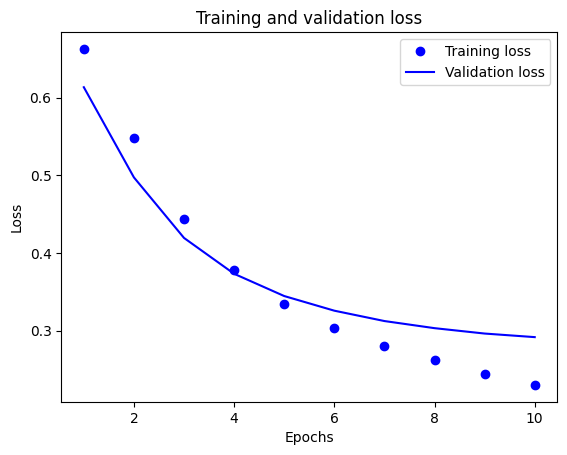

In [28]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

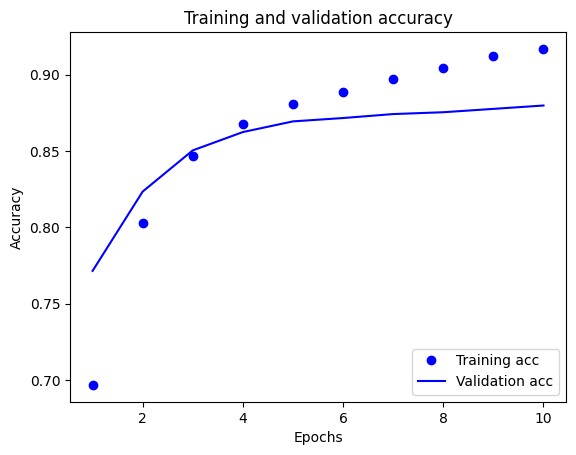

In [29]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Dans ce graphique, les points représentent la perte d'apprentissage et la précision, et les lignes pleines représentent la perte de validation et la précision.

Notez que la perte d'entraînement diminue à chaque époque et que la précision de l'entraînement augmente à chaque époque. Ceci est attendu lors de l'utilisation d'une optimisation de descente de gradient - elle doit minimiser la quantité souhaitée à chaque itération.

Ce n'est pas le cas pour la perte de validation et la précision - elles semblent culminer avant la précision de la formation. Ceci est un exemple de surajustement : le modèle fonctionne mieux sur les données d'apprentissage que sur des données qu'il n'a jamais vues auparavant. Après ce point, le modèle sur-optimise et apprend des représentations spécifiques aux données d'apprentissage qui ne se généralisent pas aux données de test.

Dans ce cas particulier, vous pouvez éviter le surajustement en arrêtant simplement l'entraînement lorsque la précision de la validation n'augmente plus. Une façon de le faire est d'utiliser le rappel tf.keras.callbacks.EarlyStopping .

## **Export the model**

In [31]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 5s 6ms/step - loss: 0.3101 - accuracy: 0.8741
0.8741199970245361


Inférence sur de nouvelles données
Pour obtenir des prédictions pour de nouveaux exemples, vous pouvez simplement appeler model.predict() .

In [34]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 37ms/step


array([[0.6162212 ],
       [0.43613088],
       [0.35448894]], dtype=float32)

Il y a une différence de performances à garder à l'esprit lorsque vous choisissez où appliquer votre couche TextVectorization. L'utiliser en dehors de votre modèle vous permet d'effectuer un traitement CPU asynchrone et une mise en mémoire tampon de vos données lors de l'entraînement sur GPU. Donc, si vous formez votre modèle sur le GPU, vous voudrez probablement utiliser cette option pour obtenir les meilleures performances lors du développement de votre modèle, puis passez à l'inclusion de la couche TextVectorization dans votre modèle lorsque vous êtes prêt à préparer le déploiement. .